In [1]:
!pip install -q -U lightautoml catboost lightgbm xgboost

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
beatrix-jupyterlab 2023.128.151533 requires jupyterlab~=3.6.0, but you have jupyterlab 4.1.6 which is incompatible.
dask-expr 1.0.11 requires pandas>=2, but you have pandas 1.5.3 which is incompatible.
featuretools 1.30.0 requires pandas>=2.0.0, but you have pandas 1.5.3 which is incompatible.
fitter 1.7.0 requires joblib<2.0.0,>=1.3.1, but you have joblib 1.2.0 which is incompatible.
libpysal 4.9.2 requires packaging>=22, but you have packaging 21.3 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
mizani 0.11.1 requires pandas>=2.1.0, but you have pandas 1.5.3 which is incompatible.
momepy 0.7.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatib

In [2]:
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sns
import pandas as pd
import numpy as np
import torch

In [3]:
TARGET_NAME = 'FloodProbability'
TEST_SIZE = 0.1
N_THREADS = 4
TIMEOUT = 3600 * 11
N_FOLDS = 5
SEED = 27

In [4]:
np.random.seed(SEED)
torch.set_num_threads(N_THREADS)

In [5]:
train = pd.read_csv('/kaggle/input/flood-prediction-precomputed-stat-features/train.csv', index_col='id')
test = pd.read_csv('/kaggle/input/flood-prediction-precomputed-stat-features/test.csv', index_col='id')

In [6]:
_train, _val = train_test_split(
    train,
    test_size=TEST_SIZE,
    random_state=SEED
)

# Training

In [7]:
task = Task(
    name='reg',
    loss='mse',
    metric='r2',
    greater_is_better=True
)

In [8]:
automl = TabularAutoML(
    task=task,
    timeout=TIMEOUT,
    cpu_limit=N_THREADS,
    reader_params={
        'n_jobs': N_THREADS,
        'cv':  N_FOLDS,
        'random_state': SEED
    },
    tuning_params = {'max_tuning_time': 1800},
)

oof_preds = automl.fit_predict(
    _train,
    roles={'target': TARGET_NAME},
    verbose=1
)

[20:10:57] Stdout logging level is INFO.
[20:10:57] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[20:10:57] Task: reg

[20:10:57] Start automl preset with listed constraints:
[20:10:57] - time: 39600.00 seconds
[20:10:57] - CPU: 4 cores
[20:10:57] - memory: 16 GB

[20:10:57] Train data shape: (1006161, 90)



/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:37: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


[20:11:15] Layer 1 train process start. Time left 39582.17 secs
[20:11:22] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[20:11:35] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.8517407322562396
[20:11:35] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[20:11:35] Time left 39562.09 secs

[20:13:24] Selector_LightGBM fitting and predicting completed
[20:13:26] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[20:22:13] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.8690636328783039
[20:22:13] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[20:22:13] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 1800.00 secs
[20:52:46] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[20:52:46] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[20:58:28] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.8691712019099995
[20:58:28] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting an

In [9]:
print(automl.create_model_str_desc())

Final prediction for new objects (level 0) = 
	 0.32272 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
	 0.67728 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) 


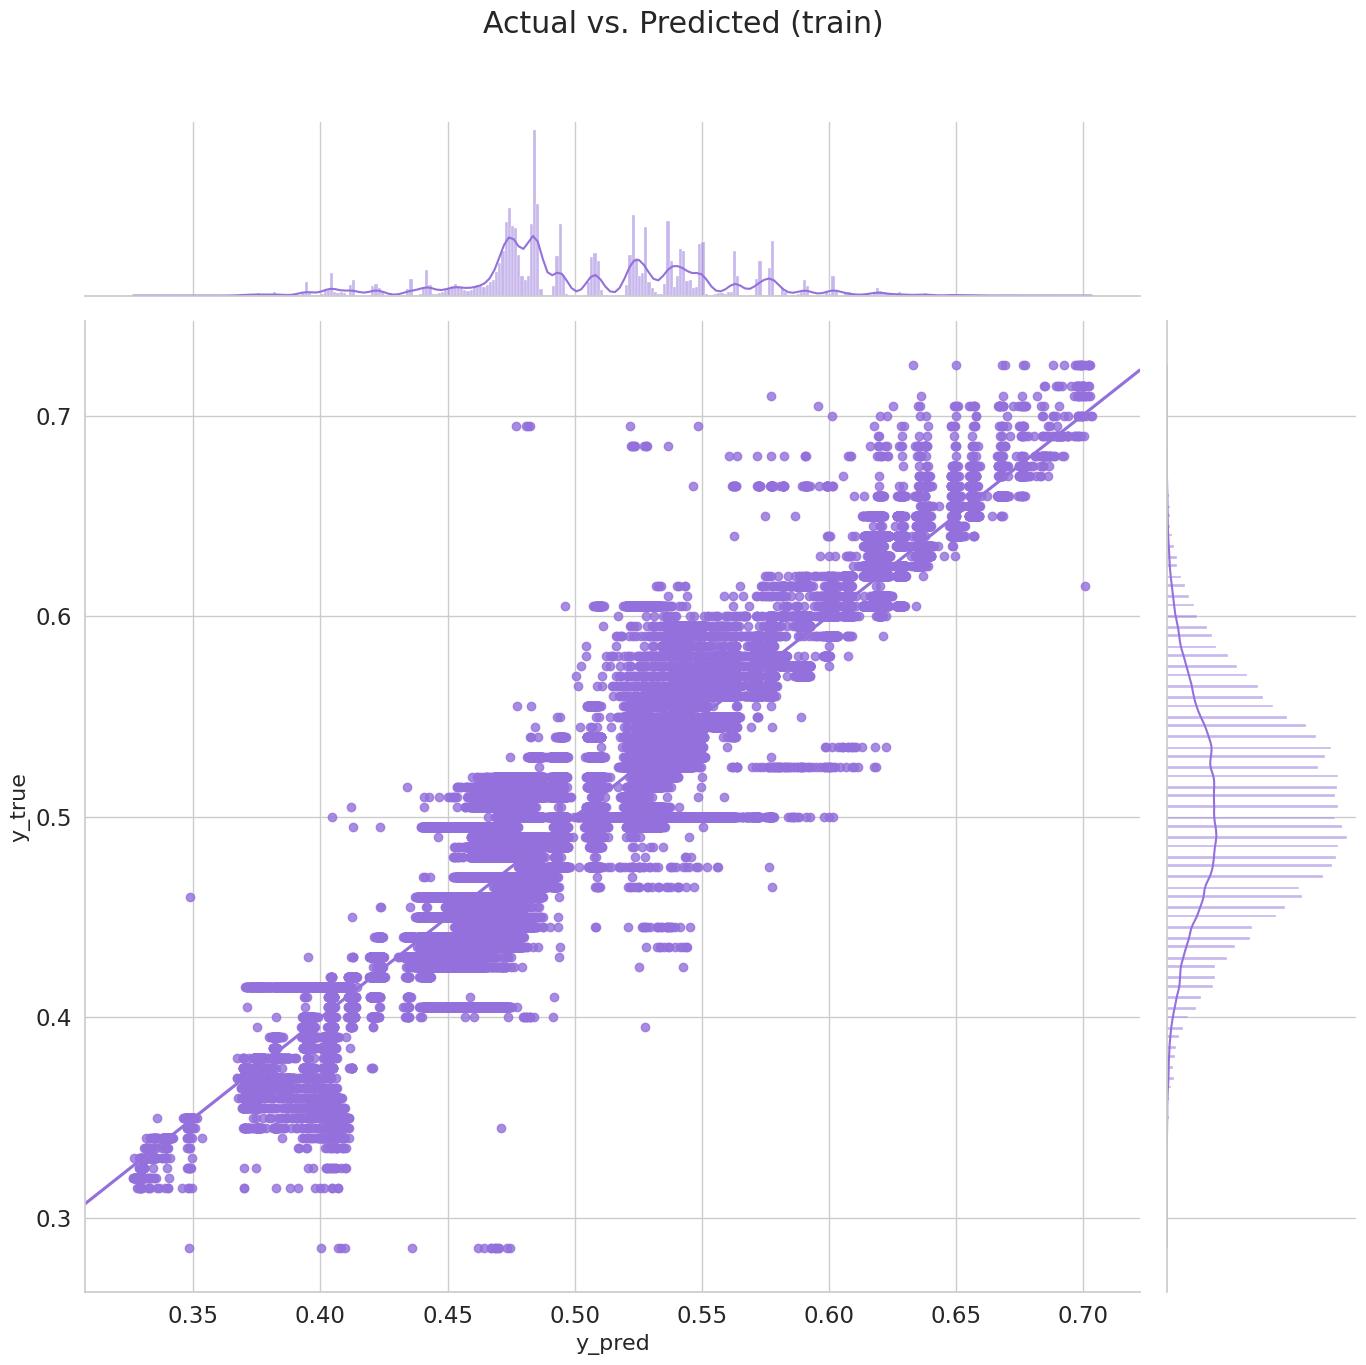

In [10]:
sns.set(style="whitegrid", font_scale=1.5)
g = sns.jointplot(
    x=oof_preds.data[:, 0],
    y=_train[TARGET_NAME],
    kind="reg",
    truncate=False,
    color='#9370DB',
    height=14,
)
g.set_axis_labels('y_pred', 'y_true', fontsize=16)
g.fig.suptitle("Actual vs. Predicted (train)")
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.9)

# Evaluating The Model on the Validation Set

In [11]:
X_val = _val.drop(columns=[TARGET_NAME])
y_val = _val[TARGET_NAME].values

y_preds = automl.predict(X_val).data[:, 0]

score = r2_score(y_val, y_preds)

print(f'R2 score: {score}')

R2 score: 0.8693086258801901


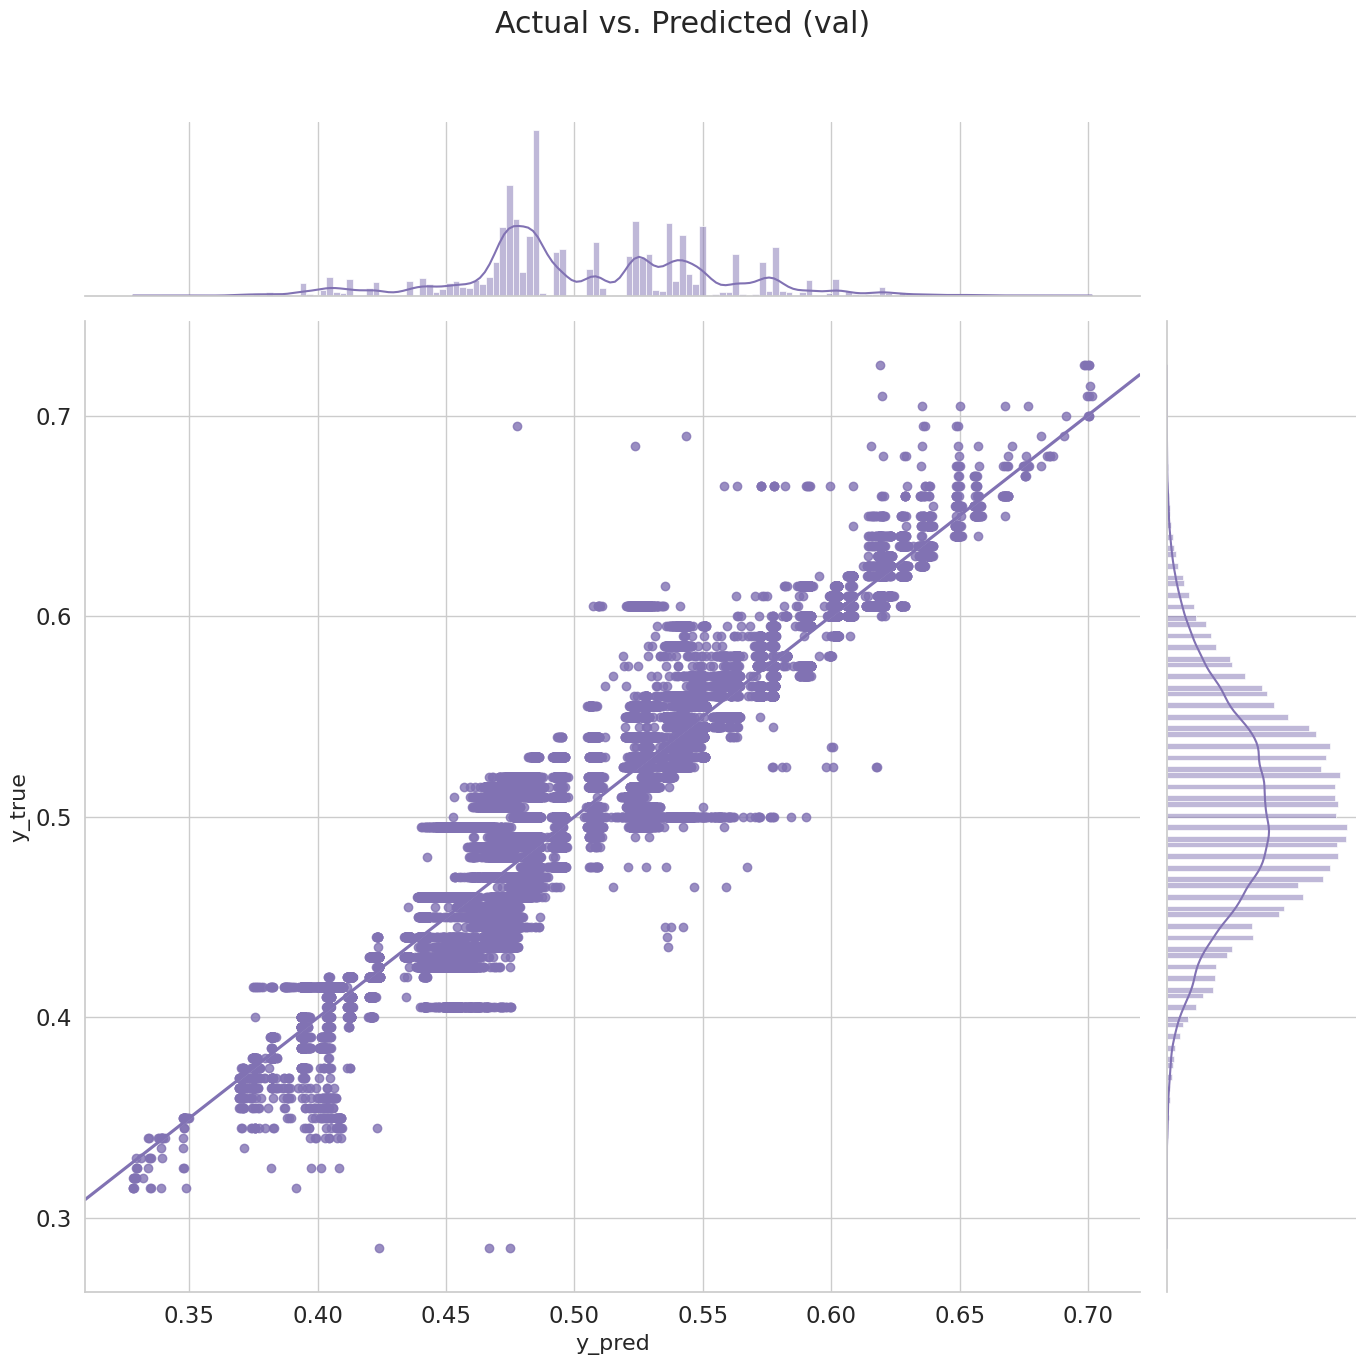

In [12]:
sns.set(style="whitegrid", font_scale=1.5)
g = sns.jointplot(
    x=y_preds,
    y=y_val,
    kind="reg",
    truncate=False,
    color='m',
    height=14,
)
g.set_axis_labels('y_pred', 'y_true', fontsize=16)
g.fig.suptitle("Actual vs. Predicted (val)")
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.9)

# Making Predictions and Creating a Submission File

In [13]:
test_preds = automl.predict(test)
submission = pd.DataFrame({'id': test.index, 'FloodProbability': test_preds.data[:, 0]})
submission.to_csv('submission.csv', index=False)
submission.head()

,id,FloodProbability
0,1117957,0.577482
1,1117958,0.456931
2,1117959,0.447907
3,1117960,0.466442
4,1117961,0.466901
